In [1]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2, SelectKBest
from scipy.stats import chi2_contingency
import re
from matplotlib.ticker import MaxNLocator
import warnings

warnings.filterwarnings('ignore')


In [2]:
sys.path.append(os.path.abspath("/home/bk_anupam/code/ML/ML_UTILS/"))
import data_utils

In [3]:
df_train = pd.read_csv("./data/train.csv")
df_test = pd.read_csv("./data/test.csv")

In [4]:
df_train.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [8]:
print(f"df_train.shape = {df_train.shape}, df_test.shape = {df_test.shape}")
print("Train null information")
data_utils.get_null_stats(df_train)
print("Test null information")
data_utils.get_null_stats(df_test)

df_train.shape = (188533, 13), df_test.shape = (125690, 12)
Train null information
{'fuel_type': 5083, 'accident': 2452, 'clean_title': 21419}
Test null information
{'fuel_type': 3383, 'accident': 1632, 'clean_title': 14239}


In [10]:
_, result = data_utils.process_outliers_iqr(df_train, "price", remove_outliers=False)
result

,col_name,Q1,Q3,IQR,min_val,max_val,outlier_count,outlier_pct
0,price,17000.0,49900.0,32900.0,-32350.0,99250.0,10880,0.057709


In [11]:
_, result = data_utils.process_outliers_iqr(df_train, "milage", remove_outliers=False)
result

,col_name,Q1,Q3,IQR,min_val,max_val,outlier_count,outlier_pct
0,milage,24115.0,95400.0,71285.0,-82812.5,202327.5,1766,0.009367


In [58]:
df_train.fuel_type.value_counts()

fuel_type
Gasoline          165940
Hybrid              6832
E85 Flex Fuel       5406
Diesel              3955
–                    781
Plug-In Hybrid       521
not supported         15
Name: count, dtype: int64

In [59]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


In [60]:
# in df_train for each column with null values get the null count
null_info = df_train.isna().sum()
null_info[null_info > 0]

fuel_type       5083
accident        2452
clean_title    21419
dtype: int64

In [61]:
# for each object type column get the number of unique values sorted in descending order
df_train.select_dtypes("object").nunique().sort_values(ascending=False)

model           1897
engine          1117
ext_col          319
int_col          156
brand             57
transmission      52
fuel_type          7
accident           2
clean_title        1
dtype: int64

In [75]:
df_train.model.value_counts()

model
F-150 XLT                        2945
M3 Base                          2229
Camaro 2SS                       1709
M4 Base                          1622
Mustang GT Premium               1526
                                 ... 
IONIQ Plug-In Hybrid SEL            2
X5 3.0i                             1
X5 xDrive40e                        1
XLR Base                            1
Integra w/A-Spec Tech Package       1
Name: count, Length: 1897, dtype: int64

In [78]:
# find models whole value_counts is less than 10
df_train.model.value_counts()[df_train.model.value_counts() < 50]

model
F-250 XLT Super Duty             49
Rover Discovery LSE              49
Durango SRT                      49
Gladiator Willys                 49
ILX 2.0L w/Premium Package       49
                                 ..
IONIQ Plug-In Hybrid SEL          2
X5 3.0i                           1
X5 xDrive40e                      1
XLR Base                          1
Integra w/A-Spec Tech Package     1
Name: count, Length: 1051, dtype: int64

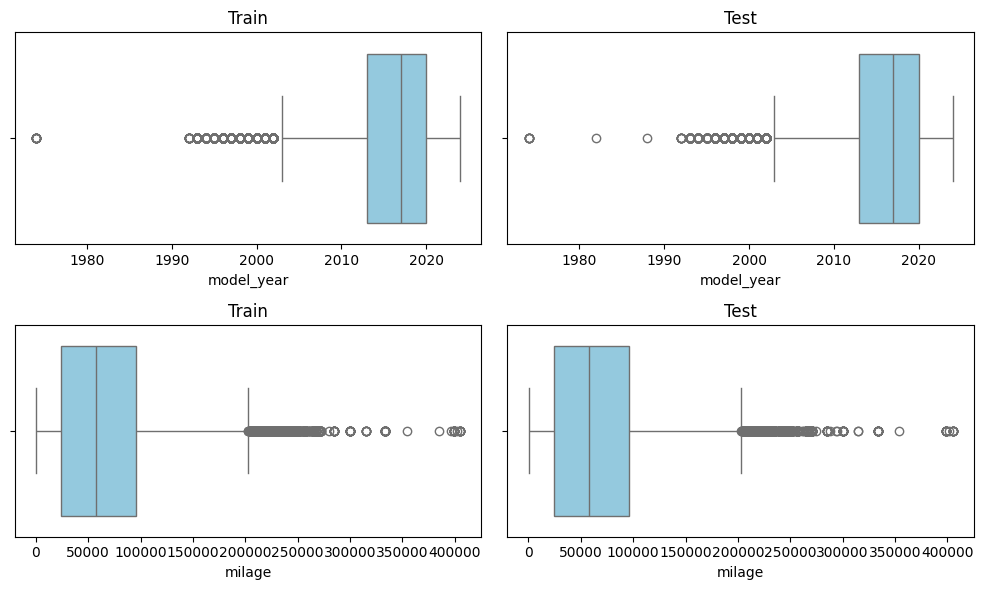

In [88]:
cols = ['model_year','milage']
data_utils.plot_box_plots(df_train, df_test, cols, fig_size=(10, 6))